На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [103]:
import numpy as np
import pandas as pd
import scipy.stats as st
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [104]:
df = pd.read_csv('AB Test Results.csv', skipinitialspace=True, decimal=",")

In [105]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [106]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [107]:
df.dtypes

USER_ID           int64
VARIANT_NAME     object
REVENUE         float64
dtype: object

<Axes: xlabel='REVENUE'>

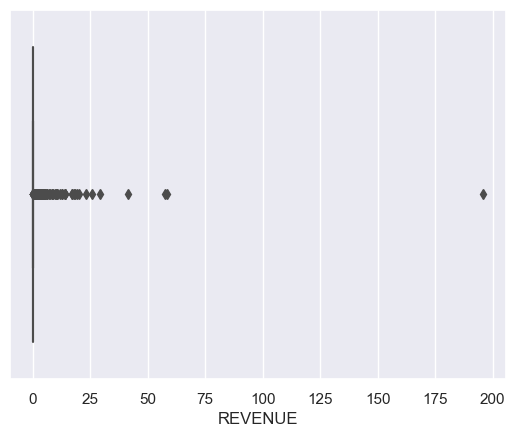

In [126]:
sns.boxplot(data=df, x=df.REVENUE)

In [109]:
#Наличие выбросов в данных
#еденичная крупная оплата
revenue_max=df.REVENUE.max()
revenue_max


196.01

In [110]:
# очистим данные от выбросов и от 0 значений
df_clear = df[df.REVENUE > 0]

df_clear = df_clear[df_clear.REVENUE < df_clear.REVENUE.quantile(0.975)]

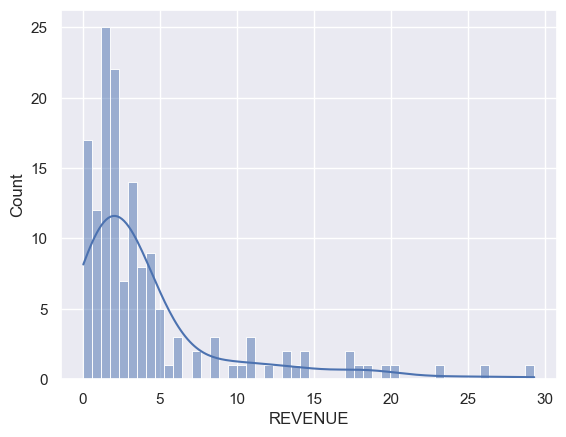

In [111]:
sns.histplot(data=df_clear, x='REVENUE', bins=50, kde=True);

In [112]:
#Проверим независимость выборок(наличие пользователя в 2 группах)
users_in_two_groups = df_clear.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique})
users_in_two_groups.query('VARIANT_NAME > 1')

,USER_ID,VARIANT_NAME
25,1252,2


In [113]:
# Поскольку данные зависимые, а распределение не нормальное, то попробуем использовать критерий Вилкиксона
sample_a = df_clear[df_clear.VARIANT_NAME=="control"]
sample_b = df_clear[df_clear.VARIANT_NAME=="variant"]

# Поскольку критерий Вилкиксона используется для двух парных групп то количество результатов в каждой группе должно быть одинаковое
len(sample_a) == len(sample_b)

False

In [114]:
#Невозможно использовать критерий Вилкиксона  - группы не равны

In [115]:
# Исключим данного пользователя из выборки
df_clear=df_clear[df_clear.USER_ID!=1252]

In [116]:
# Проверим
users_in_two_groups = df_clear.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique})
users_in_two_groups.query('VARIANT_NAME > 1')

,USER_ID,VARIANT_NAME


In [117]:
# Разобъем на группы
sample_a = df_clear[df_clear.VARIANT_NAME=="control"]
sample_b = df_clear[df_clear.VARIANT_NAME=="variant"]

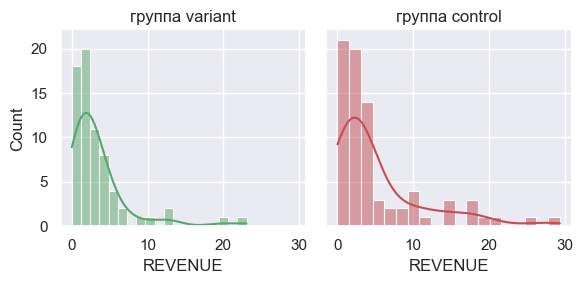

In [118]:
d = {'color': ['g', 'r']}
sns.set(style='darkgrid')
g = sns.FacetGrid(data=df_clear, col ='VARIANT_NAME', col_wrap=2, hue_kws=d, hue='VARIANT_NAME')
g.map(sns.histplot, 'REVENUE', kde=True)
g.set_titles(col_template="группа {col_name}");


In [119]:
# Поскольку распределение не нормальное(логарифмическое) и данные количественные используем критерий Манна-Уитни для сравнения групп
test_result = st.mannwhitneyu(sample_a.REVENUE, sample_b.REVENUE)
print(test_result)

MannwhitneyuResult(statistic=3127.5, pvalue=0.06507666473835383)


Поскольу по умолчанию $\alpha = 0.05$ 

In [120]:
if test_result.pvalue > 0.05:
    print("Статистически значимых различий между группами не выявлено. Эксперимент по увеличеню дохода признан неудачным. Не внедрять изменения на сайте")
else:
    print("Статистически значимые различия между группами выявлены. Эксперимент по увеличеню дохода признан удачным. Необходимо внедрять изменения на сайте")

Статистически значимых различий между группами не выявлено. Эксперимент по увеличеню дохода признан неудачным. Не внедрять изменения на сайте
